# Generate Hubert Codes and their CTC word segmentations for English Speech

(use conda env huggingface for this notebook)

# imports

In [153]:
import torch
from transformers import HubertForCTC, Wav2Vec2Processor
from datasets import load_dataset
import soundfile as sf
import torchaudio
import librosa
import pickle 
from tqdm import tqdm
import os
import unicodedata
import re
from dataclasses import dataclass
from collections import Counter
import textgrid
import IPython
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# from matplotlib.ticker import StrMethodFormatter

matplotlib.rcParams.update({'figure.figsize': [20, 6]})
matplotlib.rcParams.update({'figure.dpi': 200})
matplotlib.rcParams.update({'font.size': 8})
# # plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places

# check cuda

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# load pretrained model and text processor

In [3]:
processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")
model = HubertForCTC.from_pretrained("facebook/hubert-large-ls960-ft").to(device)

### examine the labels for each output id of the processor.tokenizer

In [4]:
tokenizer_output_vocab = processor.tokenizer.get_vocab()
print("tokenizer_output_vocab")
tokenizer_output_vocab

tokenizer_output_vocab


{'<pad>': 0,
 '<s>': 1,
 '</s>': 2,
 '<unk>': 3,
 '|': 4,
 'E': 5,
 'T': 6,
 'A': 7,
 'O': 8,
 'N': 9,
 'I': 10,
 'H': 11,
 'S': 12,
 'R': 13,
 'D': 14,
 'L': 15,
 'U': 16,
 'M': 17,
 'W': 18,
 'C': 19,
 'F': 20,
 'G': 21,
 'Y': 22,
 'P': 23,
 'B': 24,
 'V': 25,
 'K': 26,
 "'": 27,
 'X': 28,
 'J': 29,
 'Q': 30,
 'Z': 31}

# Get wavs

In [15]:
wav_dir = "/Users/margaretlin/Mt/UoE/Dissertation/data/LJSpeech/audio_data/LJSpeech-1.1/wavs" # LJSpeech wavs no additional processing
wavs = os.listdir(wav_dir)
wav_paths = [os.path.join(wav_dir, wav) for wav in wavs]
print(len(wav_paths))

13100


# Get text transcripts for WAVS and further normalise out non-apostrophe punctuation and make upper case

In [6]:
# load all text data and normalise to upper case, and only keep apostrophes
def text_normalize(text):
    """taken from https://github.com/Kyubyong/tacotron/blob/master/data_load.py"""
    vocab = " ABCDEFGHIJKLMNOPQRSTUVWXYZ'"
    text = ''.join(char for char in unicodedata.normalize('NFD', text)
                           if unicodedata.category(char) != 'Mn') # Strip accents
    text = re.sub("[^{}]".format(vocab), " ", text)
    text = re.sub("[ ]+", " ", text)
    text = text.rstrip()
    return text

with open("/Users/margaretlin/Mt/UoE/Dissertation/data/LJSpeech/audio_data/LJSpeech-1.1/metadata.csv") as f: # original LJ Speech transcript
    lines = f.readlines()
    
norm_text = {}
transcript_output_vocab = set()

for line in lines:
    # grab normed text
    utt_id = line.split('|')[0]
    text = line.split('|')[-1]
    # further normalise
    text = text.rstrip('\n').upper()
    text = text_normalize(text)
    
    # add all chars to vocab
    transcript_output_vocab.update(text)
    
    norm_text[utt_id] = text

# determine vocab in corpus
print("transcript_output_vocab")
transcript_output_vocab
# print(norm_text)
# {'LJ001-0001': 'PRINTING IN THE ONLY SENSE WITH WHICH WE ARE AT PRESENT CONCERNED DIFFERS FROM MOST IF NOT FROM ALL THE ARTS AND CRAFTS REPRESENTED IN THE EXHIBITION', 
#  'LJ001-0002': 'IN BEING COMPARATIVELY MODERN',
#   ...
# }

transcript_output_vocab


{' ',
 "'",
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z'}

# Get CTC HuBERT text targets from normalised text

In [7]:
# process norm text into targets for CTC HuBERT 
ctc_targets_text = {}
for utt_id, text in list(norm_text.items()):
    #convert text to IDs
    with processor.as_target_processor():
        processed = processor(text).input_ids
    #convert ids back to tokens
    tokens = processor.tokenizer.convert_ids_to_tokens(processed, skip_special_tokens=False)
    assert '<unk>' not in tokens
    assert '<s>' not in tokens
    assert '</s>' not in tokens
    assert '<pad>' not in tokens
    ctc_targets_text[utt_id] = "".join(tokens)

In [8]:
# print (ctc_targets_text)
# 'LJ001-0001': 'PRINTING|IN|THE|ONLY|SENSE|WITH|WHICH|WE|ARE|AT|PRESENT|CONCERNED|DIFFERS|FROM|MOST|IF|NOT|FROM|ALL|THE|ARTS|AND|CRAFTS|REPRESENTED|IN|THE|EXHIBITION',
#   ...
# }

for utt_id, ctc_text in list(ctc_targets_text.items())[:5]:
    print(utt_id, "\n", norm_text[utt_id], "\n", ctc_text, "\n")

LJ001-0001 
 PRINTING IN THE ONLY SENSE WITH WHICH WE ARE AT PRESENT CONCERNED DIFFERS FROM MOST IF NOT FROM ALL THE ARTS AND CRAFTS REPRESENTED IN THE EXHIBITION 
 PRINTING|IN|THE|ONLY|SENSE|WITH|WHICH|WE|ARE|AT|PRESENT|CONCERNED|DIFFERS|FROM|MOST|IF|NOT|FROM|ALL|THE|ARTS|AND|CRAFTS|REPRESENTED|IN|THE|EXHIBITION 

LJ001-0002 
 IN BEING COMPARATIVELY MODERN 
 IN|BEING|COMPARATIVELY|MODERN 

LJ001-0003 
 FOR ALTHOUGH THE CHINESE TOOK IMPRESSIONS FROM WOOD BLOCKS ENGRAVED IN RELIEF FOR CENTURIES BEFORE THE WOODCUTTERS OF THE NETHERLANDS BY A SIMILAR PROCESS 
 FOR|ALTHOUGH|THE|CHINESE|TOOK|IMPRESSIONS|FROM|WOOD|BLOCKS|ENGRAVED|IN|RELIEF|FOR|CENTURIES|BEFORE|THE|WOODCUTTERS|OF|THE|NETHERLANDS|BY|A|SIMILAR|PROCESS 

LJ001-0004 
 PRODUCED THE BLOCK BOOKS WHICH WERE THE IMMEDIATE PREDECESSORS OF THE TRUE PRINTED BOOK 
 PRODUCED|THE|BLOCK|BOOKS|WHICH|WERE|THE|IMMEDIATE|PREDECESSORS|OF|THE|TRUE|PRINTED|BOOK 

LJ001-0005 
 THE INVENTION OF MOVABLE METAL LETTERS IN THE MIDDLE OF THE FIFTEENTH CEN

# Load LJspeech quantised using hubert (provided by Facebook)
Do this to check that number of timesteps agrees with what huggingface Hubert model outputs
So that we do not need to regenerate the hubert codes from scratch

In [9]:
# load ljspeech hubert codes from disk into dictionary
with open("/Users/margaretlin/Mt/UoE/Dissertation/fairseq/examples/speech_audio_corrector/lj_speech_quantized.txt") as f:
    lines = f.readlines()

fb_hubert_codes = {}
for l in lines:
    utt_id, codes = l.split('|')
    codes = codes.split(' ')
    codes = [int(c) for c in codes]
    fb_hubert_codes[utt_id] = codes
    
# fb_hubert_codes.values()

# Generate frame-wise label probability

In [127]:
wav_path = wav_paths[8]

def utt_id_from_wav_path(wav_path, corpus="ljspeech"):
    if corpus == "ljspeech":
        return wav_path.split('/')[-1].split('.')[0]
    else:
        raise NotImplementedError 

utt_id = utt_id_from_wav_path(wav_path)

print(wav_path)
print(utt_id)
print(norm_text[utt_id])

/Users/margaretlin/Mt/UoE/Dissertation/data/LJSpeech/audio_data/LJSpeech-1.1/wavs/LJ031-0068.wav
LJ031-0068
WHILE THESE MEDICAL EFFORTS WERE IN PROGRESS


### pass audio through model

In [128]:
ljspeech_sampling_rate = 22050
hubert_sampling_rate = 16000

def model_forward(wav_path):
    # load speech and resample to same rate as hubert encoder requires
    speech, _ = sf.read(wav_path)
    speech = librosa.resample(speech, ljspeech_sampling_rate, hubert_sampling_rate)

    # get audio inputs for hubert
    input_values = processor(speech, return_tensors="pt", sampling_rate=hubert_sampling_rate).input_values.to(device)

    # use hubert to encode audio inputs to logits over output vocabulary (characters)
    emission = model(input_values).logits # logits should be result of log_softmaxing outputs of model?
    emission = torch.log_softmax(emission, dim=-1, dtype=torch.float32)
    return emission

emission = model_forward(wav_path)

# check shapes
# print("input_values.size()", input_values.size()) # (b_sz, n_waveform_samples)
print("emission.size()", emission.size()) # (b_sz, n_frames, n_output_labels)
print(emission)

/var/folders/n9/wbmr75q14sbgx1rd5y4xhtjc0000gn/T/ipykernel_56344/2594822135.py:7: FutureWarning: Pass orig_sr=22050, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  speech = librosa.resample(speech, ljspeech_sampling_rate, hubert_sampling_rate)


emission.size() torch.Size([1, 126, 32])
tensor([[[-3.4570e-05, -4.1892e+01, -4.1510e+01,  ..., -1.9438e+01,
          -2.0944e+01, -2.1437e+01],
         [-5.1682e+00, -3.6886e+01, -3.6609e+01,  ..., -1.5740e+01,
          -1.6249e+01, -1.9804e+01],
         [-3.7936e+00, -3.9840e+01, -3.9977e+01,  ..., -2.2656e+01,
          -2.4074e+01, -2.4640e+01],
         ...,
         [-7.0333e-06, -3.9112e+01, -3.8533e+01,  ..., -2.0591e+01,
          -2.0949e+01, -2.0512e+01],
         [-1.8000e-05, -3.8929e+01, -3.8884e+01,  ..., -1.8628e+01,
          -2.1189e+01, -1.9306e+01],
         [-8.9165e-05, -3.8587e+01, -3.8370e+01,  ..., -1.7612e+01,
          -2.0585e+01, -1.9711e+01]]], grad_fn=<LogSoftmaxBackward0>)


### check if len of model CTC ASR outputs matches with hubert discrete codes provided by fb

In [129]:
print("len of fb codes", len(fb_hubert_codes[utt_id]), "len of model outputs", emission.size(1))
assert len(fb_hubert_codes[utt_id]) == emission.size(1)

len of fb codes 126 len of model outputs 126


### compare ASR output with ground truth transcription (sanity check)

In [130]:
# inspect ASR decoded transcription vs ground truth transcription
predicted_ids = torch.argmax(emission, dim=-1)
asr_output = processor.decode(predicted_ids[0])
print("utt_id", utt_id)
print("asr_output", asr_output)
print("real_transcript", norm_text[utt_id])

utt_id LJ031-0068
asr_output WHILE THESE MEDICAL EFFORTS WERE IN PROGRESS
real_transcript WHILE THESE MEDICAL EFFORTS WERE IN PROGRESS


### visualise output emission/logits

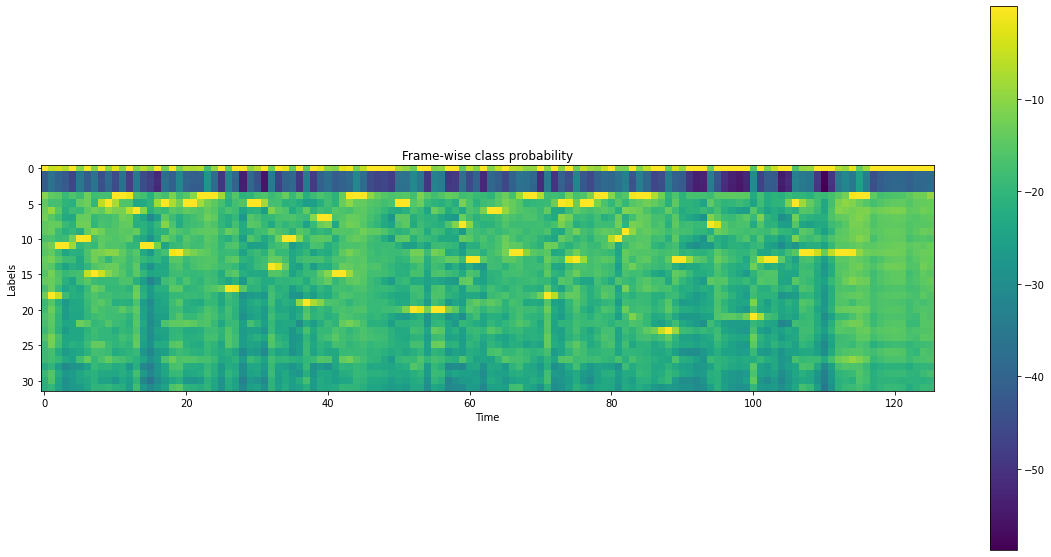

In [131]:
plt.imshow(emission[0].cpu().detach().T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

# Generate alignment probability (trellis)

In [132]:
emission.size()

torch.Size([1, 126, 32])

In [133]:
transcript = ctc_targets_text[utt_id]
tokens = [tokenizer_output_vocab[c] for c in transcript]
print(utt_id, ctc_targets_text[utt_id])
print(list(zip(transcript, tokens)))

def get_trellis(emission, tokens, blank_id=0):
    """
    emission (n_frames, n_output_labels) # NB no b_sz!
    tokens (n_tokens)
    """
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    # Trellis has extra diemsions for both time axis and tokens.
    # The extra dim for tokens represents <SoS> (start-of-sentence)
    # The extra dim for time axis is for simplification of the code.
    trellis = torch.full((num_frame+1, num_tokens+1), -float('inf')).to(device)
    trellis[:, 0] = 0
    for t in range(num_frame):
        trellis[t+1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens],
        )
    return trellis

# NB 
trellis = get_trellis(emission[0], tokens)

LJ031-0068 WHILE|THESE|MEDICAL|EFFORTS|WERE|IN|PROGRESS
[('W', 18), ('H', 11), ('I', 10), ('L', 15), ('E', 5), ('|', 4), ('T', 6), ('H', 11), ('E', 5), ('S', 12), ('E', 5), ('|', 4), ('M', 17), ('E', 5), ('D', 14), ('I', 10), ('C', 19), ('A', 7), ('L', 15), ('|', 4), ('E', 5), ('F', 20), ('F', 20), ('O', 8), ('R', 13), ('T', 6), ('S', 12), ('|', 4), ('W', 18), ('E', 5), ('R', 13), ('E', 5), ('|', 4), ('I', 10), ('N', 9), ('|', 4), ('P', 23), ('R', 13), ('O', 8), ('G', 21), ('R', 13), ('E', 5), ('S', 12), ('S', 12)]


### visualise

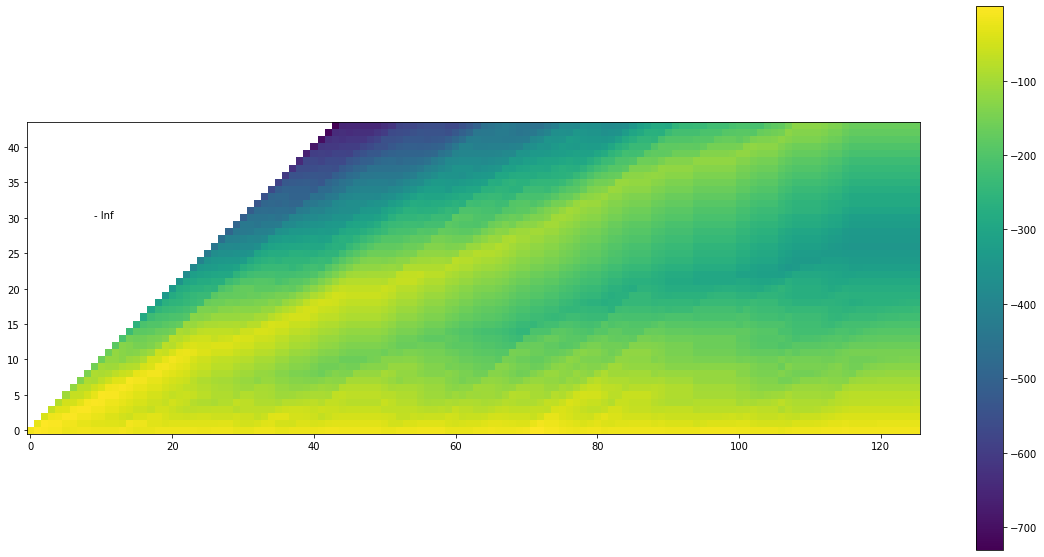

In [134]:
plt.imshow(trellis[1:, 1:].cpu().detach().T, origin='lower')
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.rcParams["figure.figsize"] = (20,10) # change plot size
plt.show()

# Find the most likely path (backtracking)

In [135]:
@dataclass
class Point:
  token_index: int
  time_index: int
  score: float


def backtrack(trellis, emission, tokens, blank_id=0):
  # Note:
  # j and t are indices for trellis, which has extra dimensions
  # for time and tokens at the beginning.
  # When refering to time frame index `T` in trellis,
  # the corresponding index in emission is `T-1`.
  # Similarly, when refering to token index `J` in trellis,
  # the corresponding index in transcript is `J-1`.
  j = trellis.size(1) - 1
  t_start = torch.argmax(trellis[:, j]).item()

  path = []
  for t in range(t_start, 0, -1):
    # 1. Figure out if the current position was stay or change
    # Note (again):
    # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
    # Score for token staying the same from time frame J-1 to T.
    stayed = trellis[t-1, j] + emission[t-1, blank_id]
    # Score for token changing from C-1 at T-1 to J at T.
    changed = trellis[t-1, j-1] + emission[t-1, tokens[j-1]]

    # 2. Store the path with frame-wise probability.
    prob = emission[t-1, tokens[j-1] if changed > stayed else 0].exp().item()
    # Return token index and time index in non-trellis coordinate.
    path.append(Point(j-1, t-1, prob))

    # 3. Update the token
    if changed > stayed:
      j -= 1
      if j == 0:
        break
  else:
    raise ValueError('Failed to align')
  return path[::-1]

path = backtrack(trellis, emission[0], tokens)
# for path in path:
#     print(path)
# print(type(path))

### visualise

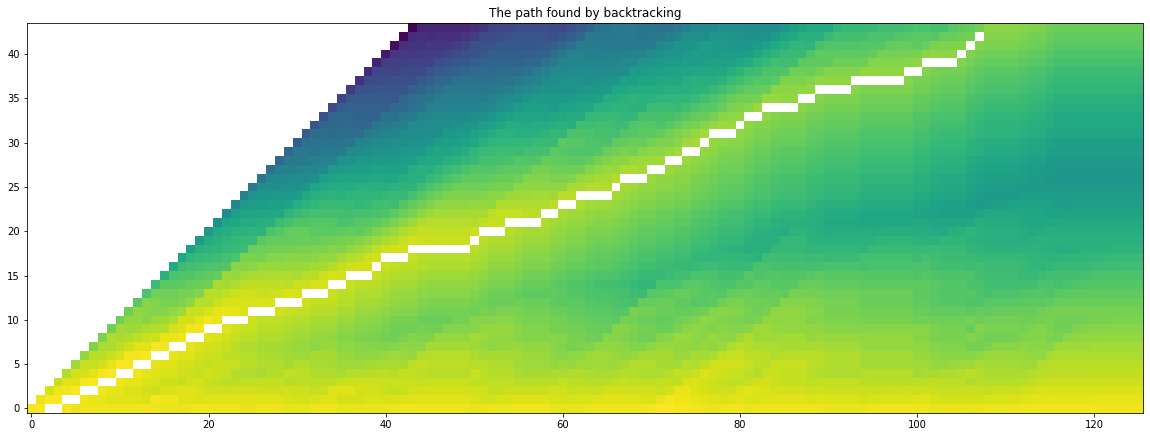

In [136]:
def plot_trellis_with_path(trellis, path):
  # To plot trellis with path, we take advantage of 'nan' value
  trellis_with_path = trellis.clone()
  for i, p in enumerate(path):
    trellis_with_path[p.time_index, p.token_index] = float('nan')
  plt.imshow(trellis_with_path[1:, 1:].T, origin='lower')

plot_trellis_with_path(trellis.cpu().detach(), path)
plt.title("The path found by backtracking")
plt.show()

### merge labels

In [137]:
# Merge the labels
@dataclass
class Segment:
  label: str
  start: int
  end: int
  score: float

  def __repr__(self):
    return f"{self.label}\t(score:{self.score:4.2f}) - [start:{self.start:5d}, end:{self.end:5d}) - dur:{self.end-self.start:5d}"

  @property
  def length(self):
    return self.end - self.start

def merge_repeats(path, transcript):
  i1, i2 = 0, 0
  segments = []
  while i1 < len(path):
    while i2 < len(path) and path[i1].token_index == path[i2].token_index:
      i2 += 1
    score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
    segments.append(Segment(transcript[path[i1].token_index], path[i1].time_index, path[i2-1].time_index + 1, score))
    i1 = i2
  return segments

segments = merge_repeats(path, transcript)
for seg in segments:
  print(seg)

#print(segments)

W	(score:0.51) - [start:    1, end:    3) - dur:    2
H	(score:1.00) - [start:    3, end:    5) - dur:    2
I	(score:0.72) - [start:    5, end:    7) - dur:    2
L	(score:0.99) - [start:    7, end:    9) - dur:    2
E	(score:0.54) - [start:    9, end:   11) - dur:    2
|	(score:0.90) - [start:   11, end:   13) - dur:    2
T	(score:0.50) - [start:   13, end:   15) - dur:    2
H	(score:1.00) - [start:   15, end:   17) - dur:    2
E	(score:0.85) - [start:   17, end:   19) - dur:    2
S	(score:0.50) - [start:   19, end:   21) - dur:    2
E	(score:0.50) - [start:   21, end:   23) - dur:    2
|	(score:0.67) - [start:   23, end:   26) - dur:    3
M	(score:0.90) - [start:   26, end:   29) - dur:    3
E	(score:0.67) - [start:   29, end:   32) - dur:    3
D	(score:0.69) - [start:   32, end:   35) - dur:    3
I	(score:1.00) - [start:   35, end:   37) - dur:    2
C	(score:0.71) - [start:   37, end:   40) - dur:    3
A	(score:1.00) - [start:   40, end:   41) - dur:    1
L	(score:0.46) - [start:   4

### visualise trellis with segments and labels

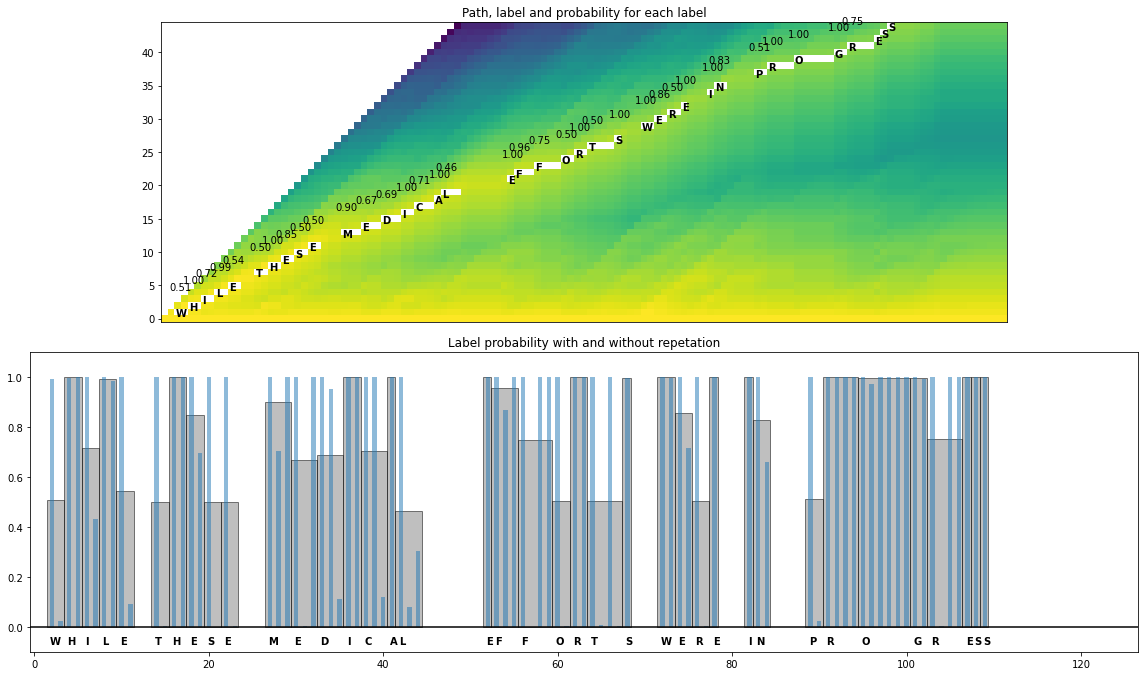

In [138]:
def plot_trellis_with_segments(trellis, segments, transcript):
  # To plot trellis with path, we take advantage of 'nan' value
  trellis_with_path = trellis.clone()
  for i, seg in enumerate(segments):
    if seg.label != '|':
      trellis_with_path[seg.start+1:seg.end+1, i+1] = float('nan')

  fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))
  ax1.set_title("Path, label and probability for each label")
  ax1.imshow(trellis_with_path.T, origin='lower')
  ax1.set_xticks([])

  for i, seg in enumerate(segments):
    if seg.label != '|':
      ax1.annotate(seg.label, (seg.start + .7, i + 0.3), weight='bold')
      ax1.annotate(f'{seg.score:.2f}', (seg.start - .3, i + 4.3))

  ax2.set_title("Label probability with and without repetation")
  xs, hs, ws = [], [], []
  for seg in segments:
    if seg.label != '|':
      xs.append((seg.end + seg.start) / 2 + .4)
      hs.append(seg.score)
      ws.append(seg.end - seg.start)
      ax2.annotate(seg.label, (seg.start + .8, -0.07), weight='bold')
  ax2.bar(xs, hs, width=ws, color='gray', alpha=0.5, edgecolor='black')

  xs, hs = [], []
  for p in path:
    label = transcript[p.token_index]
    if label != '|':
      xs.append(p.time_index + 1)
      hs.append(p.score)

  ax2.bar(xs, hs, width=0.5, alpha=0.5)
  ax2.axhline(0, color='black')
  ax2.set_xlim(ax1.get_xlim())
  ax2.set_ylim(-0.1, 1.1)

plot_trellis_with_segments(trellis.cpu().detach(), segments, transcript)
plt.tight_layout()
plt.show()

### segment the original audio into segmented audio and listen to them to see if the segmentation is correct

In [139]:
# Merge words
def merge_words(segments, separator='|'):
  words = []
  i1, i2 = 0, 0
  # print(len(segments))
  while i1 < len(segments):
    if i2 >= len(segments) or segments[i2].label == separator:
      if i1 != i2:
        segs = segments[i1:i2]
        word = ''.join([seg.label for seg in segs])
        # print(word)
        # print(segments[i1].start)
        score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
        words.append(Segment(word, segments[i1].start, segments[i2-1].end, score))
      i1 = i2 + 1
      i2 = i1
    else:
      i2 += 1
  return words
  

word_segments = merge_words(segments)
for word in word_segments:
  print(word)

print(word_segments)

WHILE	(score:0.75) - [start:    1, end:   11) - dur:   10
THESE	(score:0.67) - [start:   13, end:   23) - dur:   10
MEDICAL	(score:0.74) - [start:   26, end:   44) - dur:   18
EFFORTS	(score:0.76) - [start:   51, end:   68) - dur:   17
WERE	(score:0.82) - [start:   71, end:   78) - dur:    7
IN	(score:0.89) - [start:   81, end:   84) - dur:    3
PROGRESS	(score:0.90) - [start:   88, end:  109) - dur:   21
[WHILE	(score:0.75) - [start:    1, end:   11) - dur:   10, THESE	(score:0.67) - [start:   13, end:   23) - dur:   10, MEDICAL	(score:0.74) - [start:   26, end:   44) - dur:   18, EFFORTS	(score:0.76) - [start:   51, end:   68) - dur:   17, WERE	(score:0.82) - [start:   71, end:   78) - dur:    7, IN	(score:0.89) - [start:   81, end:   84) - dur:    3, PROGRESS	(score:0.90) - [start:   88, end:  109) - dur:   21]


### extract word level speech reps

In [140]:
def extract_startendindices(segments, separator='|'):
  words = []
  start = []
  end = []
  i1, i2 = 0, 0
  while i1 < len(segments):
    if i2 >= len(segments) or segments[i2].label == separator:
      if i1 != i2:
        segs = segments[i1:i2]
        word = ''.join([seg.label for seg in segs])
        # print(word)
        # print(segments[i1].start)
        # print(type(segments[i1].start))
        words.append(word)
        start.append(segments[i1].start)
        end.append(segments[i2-1].end)
      i1 = i2 + 1
      i2 = i1
    else:
      i2 += 1
  startend = list(zip(start, end))
  wdreps = list(zip(words, startend))
  return wdreps
  

# words, start, end = extract_startendindices(segments)
# # for word in word_segments:
# #   print(word)
# # print(words, start, end)

# startend = list(zip(start, end))

# wdreps = list(zip(words, startend))
# for i in wdreps:
#     print(i)

# wdreps = extract_startendindices(segments)
# print(type(wdreps))
# print(wdreps)

### visualise CTC word segmentation on trellis and waveform and compare with MFA alignment

In [158]:
def get_word_alignments(
    textgrid_path,
    utt_dur_from_last_word=False,
    ignore_list=('<unk>',),
):
    """
    extract word alignments from textgrid file corresponding to one utterance

    utt_dur_from_last_word: whether to set utt_dur to end timestamp of  last real wordtype, or from
    the very last alignment in the utterance (likely corresponding to silence)
    """
    tg = textgrid.TextGrid.fromFile(textgrid_path)
    words_intervaltier, _phones_intervaltier = tg
    words = []
    counter = Counter()

    for word in words_intervaltier:
        if word.mark and word.mark not in ignore_list:  # if word.mark is False then it is SILENCE
            counter[word.mark] += 1
            words.append({
                "wordtype": word.mark,
                "utt_id": textgrid_path.split('/')[-1].split('.')[0],
                "example_no": counter[word.mark],  # the number of times we have seen this word in this utterance
                "start": word.minTime,
                "end": word.maxTime,
            })

    if utt_dur_from_last_word:
        # use last real word end time as the utt_dur
        utt_dur = words[-1]['end']
    else:
        # at this point word is the last item in words_intervaltier (most likely sil / None)
        utt_dur = word.maxTime

    # add utt_dur info to all words
    for w in words:
        w["utt_dur"] = utt_dur

    return words


In [159]:
# plot mfa alignment on waveform
def plot_mfa_word_timestamps(utt_id, waveform):
  """plot mfa real timestamps onto waveform"""
  words = get_word_alignments(f"/Users/margaretlin/Mt/UoE/Dissertation/data/ljspeech_MFA_alignments_from_fb/{utt_id}.TextGrid")

  fig = plt.figure(figsize=(16, 4.75))
  ax2 = plt.gca()

  # The original waveform
  ratio = waveform.size(0) / (trellis.size(0) - 1)
  ax2.plot(waveform)
  for word in words:
    x0 = ljspeech_sampling_rate * word["start"]
    x1 = ljspeech_sampling_rate * word["end"]
    ax2.axvspan(x0, x1, alpha=0.1, color='red')
    ax2.annotate(f'{word["wordtype"]}'.upper(), (x0, 0.4))

In [160]:
def plot_mfa_hubert_spans(utt_id, waveform):
  """plot how mfa timestamps for words translate into spans of hubert code frames"""
  words = get_word_alignments(f"/Users/margaretlin/Mt/UoE/Dissertation/data/ljspeech_MFA_alignments_from_fb/{utt_id}.TextGrid")

  fig = plt.figure(figsize=(16, 4.75))
  ax2 = plt.gca()

  # The original waveform
  ratio = waveform.size(0) / (trellis.size(0) - 1)
  ax2.plot(waveform)
  for word in words:
    start_fraction = word['start'] / word['utt_dur']
    end_fraction = word['end'] / word['utt_dur']
    timesteps = trellis.size(0)
    start_frames = round(start_fraction * timesteps)
    end_frames = round(end_fraction * timesteps)
    x0 = ratio * start_frames
    x1 = ratio * end_frames
    ax2.axvspan(x0, x1, alpha=0.1, color='red')
    ax2.annotate(f'{word["wordtype"]}'.upper(), (x0, 0.4))

In [161]:
waveform, _ = torchaudio.load(wav_path)

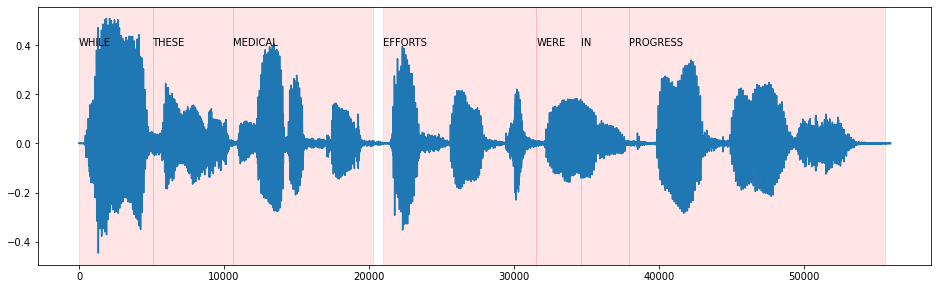

In [145]:
plot_mfa_word_timestamps(utt_id, waveform[0])

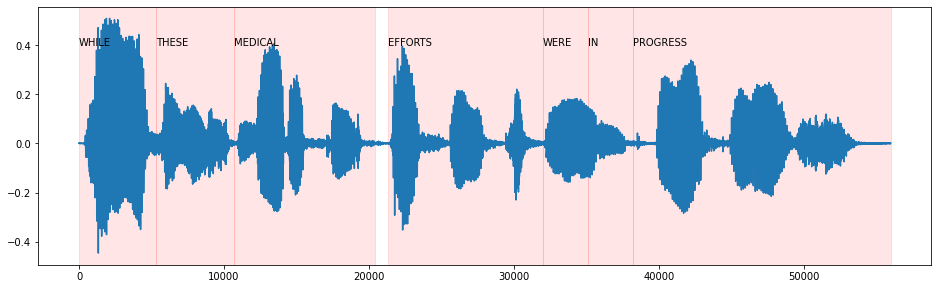

In [146]:
plot_mfa_hubert_spans(utt_id, waveform[0])

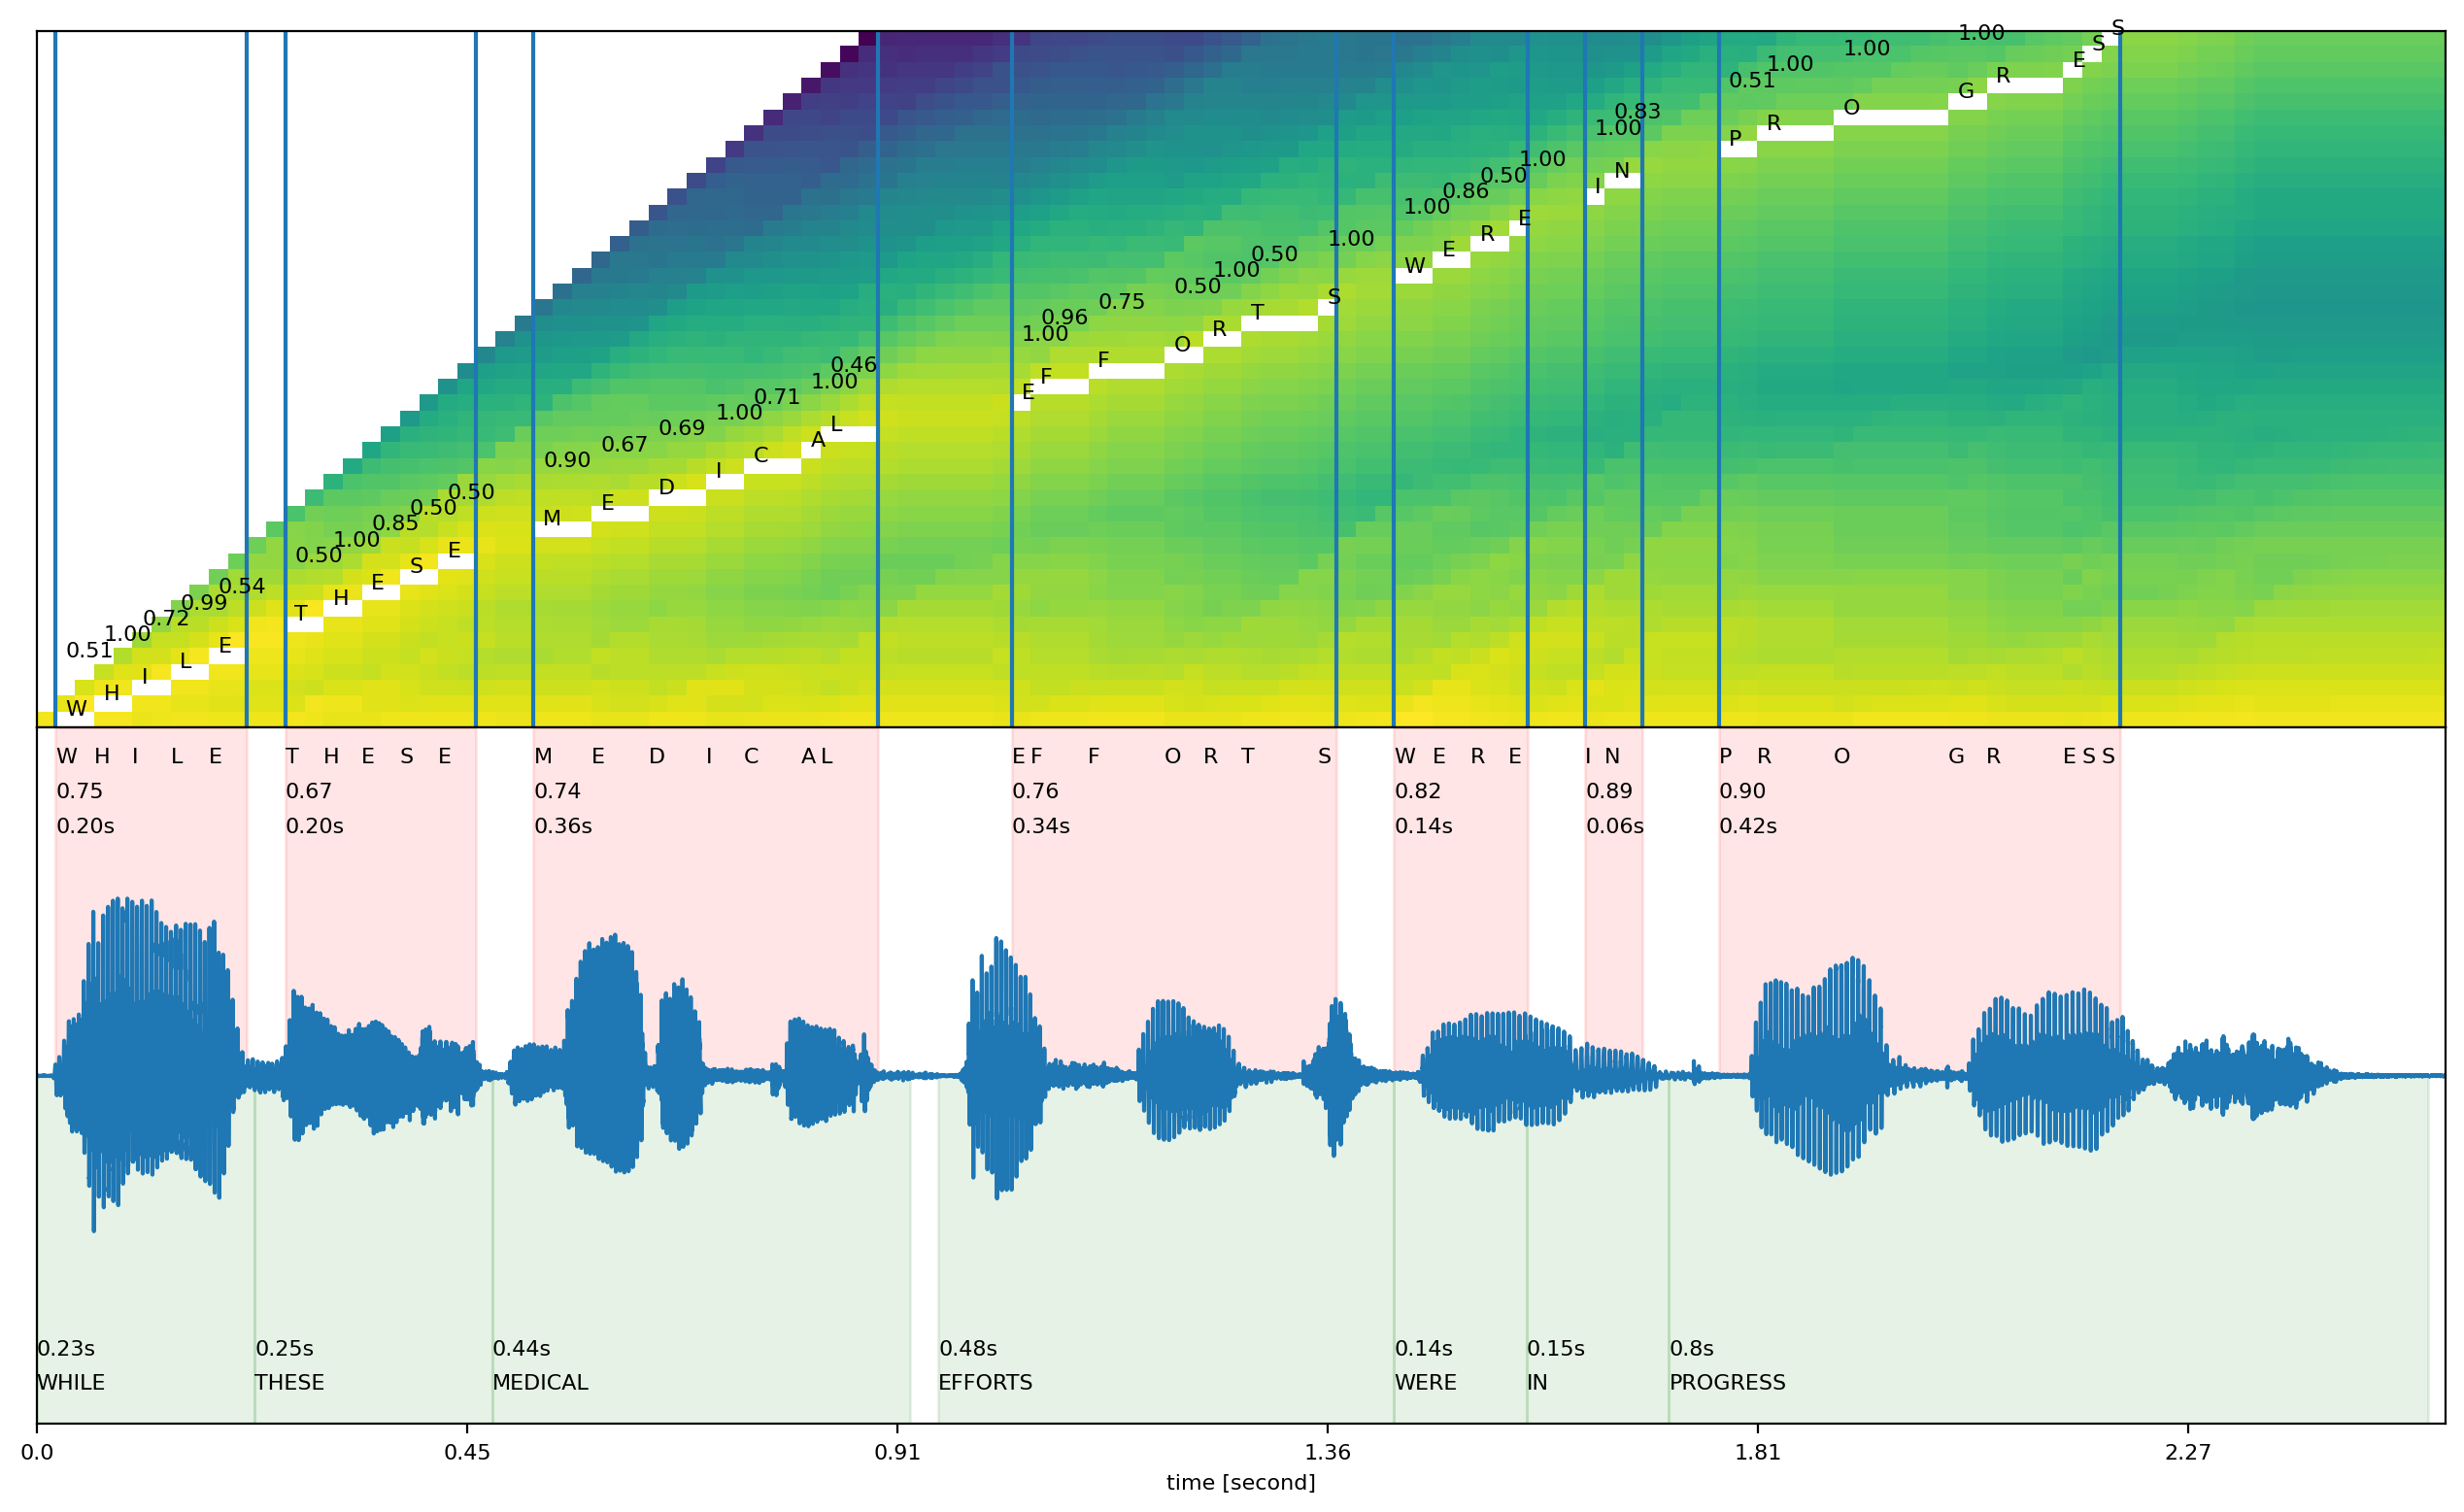

In [157]:
def plot_alignments(trellis, segments, word_segments, waveform, mfa_words=None):
  trellis_with_path = trellis.clone()
  for i, seg in enumerate(segments):
    if seg.label != '|':
      trellis_with_path[seg.start+1:seg.end+1, i+1] = float('nan')

  fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))
  fig.subplots_adjust(hspace=0.0)

  # CTC-segmentation trellis
  ax1.imshow(trellis_with_path[1:, 1:].T, origin='lower', aspect="auto")
  ax1.set_xticks([])
  ax1.set_yticks([])

  for word in word_segments:
    ax1.axvline(word.start - 0.5)
    ax1.axvline(word.end - 0.5)

  for i, seg in enumerate(segments):
    if seg.label != '|':
      ax1.annotate(seg.label, (seg.start, i + 0.3))
      ax1.annotate(f'{seg.score:.2f}', (seg.start , i + 4), fontsize=8)

  # The original waveform
  ratio = waveform.size(0) / (trellis.size(0) - 1)
  ax2.plot(waveform)
  for word in word_segments:
    x0 = ratio * word.start
    x1 = ratio * word.end
    ymin = 0.5 if mfa_words is not None else 0.0
    ax2.axvspan(x0, x1, ymin=ymin, alpha=0.1, color='red')
    ax2.annotate(f'{word.score:.2f}', (x0, 0.8))
    ax2.annotate(f'{(x1-x0)/ljspeech_sampling_rate:.2f}s', (x0, 0.7))

  for seg in segments:
    if seg.label != '|':
      ax2.annotate(seg.label, (seg.start * ratio, 0.9))
  xticks = ax2.get_xticks()
  plt.xticks(xticks, [str(round(float(timestamp), 2)) for timestamp in xticks / ljspeech_sampling_rate])
  ax2.set_xlabel('time [second]')
  ax2.set_yticks([])
  ax2.set_ylim(-1.0, 1.0)
  ax2.set_xlim(0, waveform.size(-1))
    
  # MFA Alignment
  if mfa_words is not None:
      for word in mfa_words:
        x0 = ljspeech_sampling_rate * word["start"]
        x1 = ljspeech_sampling_rate * word["end"]
        ax2.axvspan(x0, x1, ymin=0, ymax=0.5, alpha=0.1, color='green')
        ax2.annotate(f'{word["wordtype"]}'.upper(), (x0, -0.9))
        ax2.annotate(f'{round(word["end"]-word["start"], 2)}'.upper() + 's', (x0, -0.8))
        
    
waveform, _ = torchaudio.load(wav_paths[8])

mfa_words = get_word_alignments(f"/Users/margaretlin/Mt/UoE/Dissertation/data/ljspeech_MFA_alignments_from_fb/{utt_id}.TextGrid")

plot_alignments(trellis.cpu().detach(), segments, word_segments, waveform[0], mfa_words=mfa_words)
plt.savefig("comparison_mfa_ctc.svg", dpi=1200)
plt.show()

# Generate the audio for each segment

In [148]:
if not os.path.exists('_assets'):
  os.makedirs('_assets', exist_ok=True)

# A trick to embed the resulting audio to the generated file.
# `IPython.display.Audio` has to be the last call in a cell,
# and there should be only one call par cell.
def display_segment(i):
  ratio = waveform.size(1) / (trellis.size(0) - 1)
  word = word_segments[i]
  x0 = int(ratio * word.start)
  x1 = int(ratio * word.end)
  filename = f"_assets/{i}_{word.label}.wav"
  torchaudio.save(filename, waveform[:, x0:x1], ljspeech_sampling_rate)
  print(f"{word.label} (score:{word.score:.2f}): {x0 / ljspeech_sampling_rate:.3f} - {x1 / ljspeech_sampling_rate:.3f} sec - dur:{x1 / ljspeech_sampling_rate - x0 / ljspeech_sampling_rate:.3f} sec")
  return IPython.display.Audio(filename)

In [216]:
print(norm_text[utt_id])
IPython.display.Audio(wav_paths[0])

THE INSPECTORS PAID TRIBUTE TO THE EXCELLENCE OF THE MOTIVES OF THESE PHILANTHROPIC LADIES AND RECOGNIZED THE GOOD THEY DID


In [217]:
display_segment(0)

THE (score:0.78): 0.020 - 0.100 sec - dur:0.080 sec


In [218]:
display_segment(1)

INSPECTORS (score:0.88): 0.140 - 0.621 sec - dur:0.481 sec


In [219]:
display_segment(2)

PAID (score:0.81): 0.681 - 0.882 sec - dur:0.200 sec


In [220]:
display_segment(3)

TRIBUTE (score:0.69): 0.942 - 1.403 sec - dur:0.461 sec


In [221]:
display_segment(4)

TO (score:0.66): 1.583 - 1.683 sec - dur:0.100 sec


In [222]:
display_segment(5)

THE (score:0.67): 1.723 - 1.823 sec - dur:0.100 sec


In [223]:
display_segment(6)

EXCELLENCE (score:0.82): 1.944 - 2.385 sec - dur:0.441 sec


In [224]:
display_segment(7)

OF (score:0.87): 2.425 - 2.485 sec - dur:0.060 sec


In [225]:
display_segment(8)

THE (score:0.74): 2.525 - 2.625 sec - dur:0.100 sec


# Generate word-level CTC-segmentation for entire speech corpus

In [233]:
# create output directories
word_segments_outdir = "/Users/margaretlin/Mt/UoE/Dissertation/data/LJSpeech/hubert_CTC_word_segmentations"
word_segments_vis_outdir = "/Users/margaretlin/Mt/UoE/Dissertation/data/LJSpeech/hubert_CTC_word_segmentations_vis"
word_level_reps_outdir = "/Users/margaretlin/Mt/UoE/Dissertation/data/LJSpeech/hubert_CTC_word_level_reps"

os.makedirs(word_segments_outdir, exist_ok=True)
os.makedirs(word_segments_vis_outdir, exist_ok=True)
os.makedirs(word_level_reps_outdir, exist_ok=True)

In [237]:
def word_segments_from_wav_path(wav_path, remove_space_tokens_from_transcript=False):
    utt_id = utt_id_from_wav_path(wav_path)
    emission = model_forward(wav_path)
    assert len(fb_hubert_codes[utt_id]) == emission.size(1)# check seq len output by model matches hubert codes seq len
    transcript = ctc_targets_text[utt_id]
    if remove_space_tokens_from_transcript: 
        #to demonstrate affect on forcing model to align space chars affects alignment
        transcript = "".join([c for c in transcript if c != "|"]) # remove space tokens (optional)
    tokens = [tokenizer_output_vocab[c] for c in transcript]
    trellis = get_trellis(emission[0], tokens)
    path = backtrack(trellis, emission[0], tokens)
    segments = merge_repeats(path, transcript)
    word_segments = merge_words(segments)
    wdreps = extract_startendindices(segments)
    return trellis, segments, word_segments, wdreps

save_to_disk = False
visualise = False
show_vis_in_notebook = False
print_word_segments = False
continue_processing = False
save_wdreps = True

remove_space_tokens_from_transcript = False

num_to_process = None # set to None to process all

if continue_processing:
    processed_utt_ids = []
    for pickle_file in os.listdir(word_segments_outdir):
        utt_id = pickle_file.split('.')[0]
        processed_utt_ids.append(utt_id)
    print(f"Continue processing from previous checkpoint, current progress is {len(processed_utt_ids)} utts.")
else:
    processed_utt_ids = []

for wav_path in tqdm(wav_paths[:num_to_process]):
    utt_id = utt_id_from_wav_path(wav_path)
    
    if utt_id not in processed_utt_ids:
    
        trellis, segments, word_segments, wdreps = word_segments_from_wav_path(wav_path, 
                                                                       remove_space_tokens_from_transcript=remove_space_tokens_from_transcript)

        if save_to_disk:
            with open(os.path.join(word_segments_outdir, f"{utt_id}.pickle"), 'wb') as f:
                pickle.dump(word_segments, f)
        
        if save_wdreps:
            with open(os.path.join(word_level_reps_outdir, f"{utt_id}.pickle"), 'wb') as f:
                pickle.dump(wdreps, f)

        if visualise:
            if print_word_segments:
                print()
                for seg in word_segments:
                    print(seg)

            waveform, _ = torchaudio.load(wav_path)
            mfa_words = get_word_alignments(f"/Users/margaretlin/Mt/UoE/Dissertation/data/ljspeech_MFA_alignments_from_fb/{utt_id}.TextGrid")

            # TODO CHANGE FIGSIZE WIDTH DEPENDING ON HOW MANY CHARACTERS ARE IN THE SEQUENCE
            plot_alignments(trellis.cpu().detach(), segments, word_segments, waveform[0], mfa_words=mfa_words)

            if save_to_disk:
                # plt.savefig(os.path.join("/home/s1785140/fairseq/examples/speech_audio_corrector/plots", f"{utt_id}.png"), bbox_inches='tight')
                plt.savefig(os.path.join(word_segments_vis_outdir, f"{utt_id}.png"), bbox_inches='tight')

            if show_vis_in_notebook:
                plt.show()

  0%|                                                            | 0/13100 [00:00<?, ?it/s]/var/folders/n9/wbmr75q14sbgx1rd5y4xhtjc0000gn/T/ipykernel_56399/2594822135.py:7: FutureWarning: Pass orig_sr=22050, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  speech = librosa.resample(speech, ljspeech_sampling_rate, hubert_sampling_rate)
100%|█████████████████████████████████████████████| 13100/13100 [25:38:47<00:00,  7.05s/it]


In [228]:
def extract_startendindices(segments, separator='|'):
  words = []
  start = []
  end = []
  i1, i2 = 0, 0
  while i1 < len(segments):
    if i2 >= len(segments) or segments[i2].label == separator:
      if i1 != i2:
        segs = segments[i1:i2]
        word = ''.join([seg.label for seg in segs])
        # print(word)
        # print(segments[i1].start)
        # print(type(segments[i1].start))
        words.append(word)
        start.append(segments[i1].start)
        end.append(segments[i2-1].end)
      i1 = i2 + 1
      i2 = i1
    else:
      i2 += 1
  return words, start, end
  

words, start, end = extract_startendindices(segments)
# for word in word_segments:
#   print(word)
# print(words, start, end)

startend = list(zip(start, end))

wdreps = list(zip(words, startend))
for i in wdreps:
    print(i)

# print(type(wdreps))
# print(wdreps)

('FROM', (1, 9))
('A', (11, 13))
('TOWER', (18, 38))
('AT', (45, 49))
('THREE', (53, 68))
('SILHOUETTE', (75, 98))
('TARGETS', (100, 125))
('AT', (153, 158))
('DISTANCES', (162, 194))
('OF', (197, 201))
('ONE', (208, 213))
('HUNDRED', (215, 229))
('SEVENTY', (234, 253))
('FIVE', (257, 276))
('TWO', (304, 312))
('HUNDRED', (316, 330))
('FORTY', (335, 355))
('AND', (380, 385))
('TWO', (388, 396))
('HUNDRED', (399, 412))
('SIXTY', (415, 433))
('FIVE', (436, 449))
('FEET', (453, 465))
